# **Import Packages**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pythermalcomfort

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import random
from pythermalcomfort.models import pmv
from pythermalcomfort.utilities import v_relative, clo_dynamic
import xgboost as xgb
import math
import copy
import matplotlib.pyplot as plt

流式输出内容被截断，只能显示最后 5000 行内容。
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_mod

# **1. Initialization**

**1.1 Room encoding and parameters**

In [ ]:
def encoding(number, e1, e2, e3, e4, e5,
                 p1, p2, p3):

  # Room encoding: availability, type, status, area, maximum capacity
  room_availability = ['permanently_closed', 'closed', 'used']
  room_type = ['office', 'meeting_room', 'flexible_room']
  room_status = ['not_used', 'single_used', 'combined', 'divided']
  room_area = 20
  room_maximum_capacity = 3

  # Room parameters: temperature, humidity, number of occupants
  rp_temperature = 25
  rp_humidity = 0.8
  rp_num_occupant = 2

  result = [number, room_availability[e1], room_type[e2], room_status[e3],e4, e5,
            p1, p2, p3]

  return result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**1.2 Function print_other()**

In [ ]:
def print_list(l1,l2,l3,l4):
  print('Room number ', l1)
  print('Single used ',l2)
  print('Combined ', l3)
  print('Divided ', l4)
  print()

def print_all_rooms(room):
  list_name = ['No.','Availability','Type','Status','Area','Max capacity',
               'Temperature', 'Humidity', 'Num of occupants']
  list_result = []
  list_result.append(list_name)

  total_occ = 0
  total_area = 0
  for r in room:
    r = encoding(r[0],r[1],r[2],r[3],r[4],r[5],
                 r[6],r[7],r[8])
    list_result.append(r)
    total_occ = total_occ + r[8]
    total_area = total_area + r[4]

  for result in list_result:
    print(result)
  print('Total occupants: ', total_occ)
  print('Total areas: ', total_area)

def print_single_room(input_room):
  input_room[6] = round(input_room[6],3)
  input_room[7] = round(input_room[7],3)
  r = input_room
  input_room = encoding(r[0],r[1],r[2],r[3],r[4],r[5],
                        r[6],r[7],r[8])

  if input_room[3] == 'single_used':
    print('Room ', input_room)

  elif input_room[3] == 'combined':
    print('To be combined room ', input_room)

  elif input_room[3] == 'divided':
    print('To be divided room ', input_room)

  elif input_room[3] == 'not_used':
    print('To be removed room ', input_room)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **2. Updating Rules**

**2.1 Updating strategies: combine, divide, remove**

In [ ]:
def update(room, min_area,
           meeting_available_time,meeting_usage_time,
           map_th):

  # 1. Updating rooms: combine, divide, or remove
  random_updating_num = random.randint(1,3)

  # 1.1 Combine
  if random_updating_num == 1:
    room_update = rule_combine(room)

  # 1.2 Divide
  if random_updating_num == 2:
    room_update = rule_divide(room)

  # 1.3 Remove
  if random_updating_num == 3:
    room_update = rule_remove(room)

  room_temp = check(room_update, room, min_area)
  room_temp = check_meeting_room_usage_time(room_temp,
                                            room,meeting_available_time,
                                            meeting_usage_time)

  room_final = update_th(room_temp, map_th)

  return room_final


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def rule_combine(room_input):

  room_copy = copy.deepcopy(room_input)

  # 1. Number of rooms > 1
  if len(room_copy) <= 1:
      return room_copy

  # 2. To be combined r1 and r2, r1 number < r2 number
  # Dividing area is 150 m2
  total_area = 0
  for i in room_input:
    total_area = total_area + i[4]
    if total_area == 150:
      number = i[0]
  while True:
    r_num_1 = random.randint(0,len(room_input)-2)
    if r_num_1 != number-1:
      break

  r_num_2 = r_num_1 + 1
  r1 = room_copy[r_num_1]
  r2 = room_copy[r_num_2]

  # 3. Room type should be same
  if r1[2] != r2[2]:
    #print("[Error - 1] Room types are different.")
    return room_copy

  # 4. Create the new room and update maximum capacity, area, num of occupants
  room_new = copy.deepcopy(r1)
  if r1[1] == 1 and r2[1] == 1:
    room_new[1] = 1
    room_new[3] = 0
  else:
    room_new[1] = 2
    room_new[3] = 1
  room_new[4] = r1[4] + r2[4]
  room_new[5] = r1[5] + r2[5]
  room_new[8] = r1[8] + r2[8]

  # 5. Delete combined rooms in room_copy and insert the new room
  del room_copy[r_num_1]
  del room_copy[r_num_2-1]
  room_copy.insert(r_num_1, room_new)

  # 6. Order the room number r[0]
  for i in range(0, len(room_copy)):
    room_copy[i][0] = i+1

  r1[3] = 2
  r2[3] = 2
  #print('----------------------------------------------------')
  #print('Rule: COMBINE')
  #print_single_room(r1)
  #print_single_room(r2)
  #print_single_room(room_new)
  #print()

  return room_copy


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def rule_divide(room_input):
  room_copy = copy.deepcopy(room_input)

  # 1. To be divided r1
  r_num = random.randint(0,len(room_input)-1)
  r1 = room_copy[r_num]

  # 2. Create the new room and update maximum capacity, area, num of occupants
  random_number = random.randint(1, 2)
  if r1[5] % 2 == 1:
    if random_number == 1:
      max_c1 = (r1[5]+1)/2
      max_c2 = (r1[5]-1)/2
    else:
      max_c2 = (r1[5]+1)/2
      max_c1 = (r1[5]+1)/2
  else:
      max_c1 = r1[5]/2
      max_c2 = r1[5]/2

  if r1[8] % 2 == 1:
    if random_number == 1:
      occ_1 = (r1[8]+1)/2
      occ_2 = (r1[8]-1)/2
    else:
      occ_2 = (r1[8]+1)/2
      occ_1 = (r1[8]-1)/2
  else:
    occ_1 = r1[8]/2
    occ_2 = r1[8]/2

  area = r1[4]/2

  room_new_1 = copy.deepcopy(r1)
  room_new_2 = copy.deepcopy(r1)
  room_new_2[0] = room_new_2[0] + 1
  room_new_1[4] = area
  room_new_2[4] = area
  room_new_1[5] = max_c1
  room_new_2[5] = max_c2
  room_new_1[8] = occ_1
  room_new_2[8] = occ_2

  # 3. Delete the room to be divided in room_copy and insert the new rooms
  del room_copy[r_num]
  room_copy.insert(r_num, room_new_1)
  room_copy.insert(r_num+1, room_new_2)

  # 4. Order the room number r[0]
  for i in range(0, len(room_copy)):
    room_copy[i][0] = i+1

  r1[3] = 3
  #print('----------------------------------------------------')
  #print('Rule: DIVIDE')
  #print_single_room(r1)
  #print_single_room(room_new_1)
  #print_single_room(room_new_2)
  #print()

  return room_copy


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def rule_remove(room_input):

  room_copy = copy.deepcopy(room_input)

  # 1. To be removed r1
  r_num = random.randint(0,len(room_input)-1)
  r1 = room_copy[r_num]
  occ = r1[8]
  r1[1] = 1
  r1[3] = 0
  r1[8] = 0

  # 2. Re-arrange occupants
  del room_copy[r_num]
  for single_room in room_copy:
    if single_room[2] == 1:
      continue

    if single_room[1] == 1 and single_room[3] == 0:
      continue

    if single_room[8] + occ <= single_room[5]:
      single_room[8] = single_room[8] + occ
      occ = 0
      break

    else:
      if occ <= (single_room[5] - single_room[8]):
        single_room[8] = single_room[8] + occ
        occ = 0
        break

      else:
        occ = occ - (single_room[5] - single_room[8])
        single_room[8] = single_room[5]


  room_copy.insert(r_num, r1)

  room_final = []
  if occ > 0:
    room_final = room_input[:]

  else:
    room_final = room_copy[:]

  #print('----------------------------------------------------')
  #print('Rule: REMOVE')
  #print_single_room(r1)
  #print()

  return room_final

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**2.2 Check( )**

In [ ]:
def check(room_after_update, room_original, min_area):

    check_num = 0

    for single_room in room_after_update:
      # 1. Check if number of occupants  > maximum capacity of rooms
      if single_room[8] > single_room[5]:
        check_num = 1
        #print('[Error - 3] Number of occupants > maximum capacity!')

      # 2. Check if room area > minimum area (for example 5)
      if single_room[4] < min_area:
        check_num = 1
        #print('[Error - 4] Room area > minimum area!')


    if check_num == 1:
      return room_original
    else:
      #print('[Tips] No errors in num of occupants and room area.')
      return room_after_update

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def check_meeting_room_usage_time(room,room_original,
                                  meeting_available_time,meeting_usage_time):
  meeting_room = []
  for single_room in room:
    if single_room[2] == 1 and single_room[3] != 0:
      # Meeting room list: total usage time, maximum capacity
      # Example: meeting_room = [[0,3],[0,5]]
      meeting_room.append([0,single_room[5]])

  meetings = []
  total_num_meetings = 0
  plan_num_meetings = 0
  check_num = 0

  for meeting in meeting_usage_time:
    single_meeting_time, num_meetings, num_people = meeting
    plan_num_meetings = plan_num_meetings + num_meetings

    for i in range(num_meetings):
      meeting_allocated = False

      for j in meeting_room:
        if (j[0] + single_meeting_time <= meeting_available_time and num_people <= j[1]):
          j[0] = j[0] + single_meeting_time
          total_num_meetings = total_num_meetings + 1
          meeting_allocated = True
          break

  #print('[Tips] Total num of meetings ', total_num_meetings)
  #print('[Tips] Plan num of meetings ', plan_num_meetings)

  if total_num_meetings == plan_num_meetings:
    #print('[Tips] No errors in usage time of meeting rooms and number of people in meeting rooms.')
    return room

  else:
    #print('[Error - 5] Total usage time < available time of meeting rooms, or number of occupants > maximum capacity in meeting rooms!')
    return room_original


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**2.3 Update room terperature and room humidity**

In [ ]:
def update_th(room_input, map_th):
  room_copy = copy.deepcopy(room_input)

  room_area = 0
  total_area = 0

  # 1. Record the overlapping area
  record_list = []
  for single_room in room_copy:
    left_boundary = total_area
    room_area = single_room[4]
    total_area = total_area + room_area
    right_boundary = total_area

    temp_list = []
    for i in range(0,len(map_th)):
      if right_boundary > map_th[i][2] and left_boundary < map_th[i][3]:
            overlap_area_num = i + 1

      overlap_start = max(map_th[i][2], left_boundary)
      overlap_end = min(map_th[i][3], right_boundary)

      if overlap_start < overlap_end:
          temp_list.append([overlap_area_num, overlap_end - overlap_start])

    record_list.append(temp_list)

  #print('record_list ', record_list)

  # 2. Record updating temperature and humidity based on the recording list
  room_num = 0
  t_list = []
  h_list = []
  for room_overlap in record_list:
    t_new = 0
    h_new = 0

    for single_overlap in room_overlap:
      for j in map_th:
          if single_overlap[0] == j[0]:
            t_new = t_new + ((single_overlap[1] / room_copy[room_num][4]) * j[4])
            h_new = h_new + ((single_overlap[1] / room_copy[room_num][4]) * j[5])

    t_list.append(t_new)
    h_list.append(h_new)
    room_num = room_num + 1

  #print('t_list', t_list)
  #print('h_list', h_list)

  # 3. Update room temperature and humidity
  temp_num = 0
  for single_room in room_copy:
    single_room[6] = t_list[temp_num]
    single_room[7] = h_list[temp_num]
    temp_num = temp_num + 1

  return room_copy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **3. Objective Functions**

In [ ]:
# Function: f1 = f_cost = energy_cost()
def f1_cost(room):
  total_cost = 0
  total_area = 0
  model_office = xgb.Booster()
  model_office.load_model('/content/drive/MyDrive/CAI 2024_Flexible Building Space Usage Opt/xgboost_office.model')
  model_meeting = xgb.Booster()
  model_meeting.load_model('/content/drive/MyDrive/CAI 2024_Flexible Building Space Usage Opt/xgboost_meeting.model')

  cost_list = []
  area_list = []
  for single_room in room:
    if single_room[3] == 0:
      pass
    else:
      rt = single_room[6]
      rh = single_room[7]
      occ = single_room[8]
      x_array = np.array([occ,rt,rh,25,85])
      x_array = x_array.reshape(1,-1)
      d_test = xgb.DMatrix(x_array)

      if single_room[2] == 1:
        result = model_meeting.predict(d_test)

      elif single_room[2] == 0:
        result = model_office.predict(d_test)

      cost_list.append(result[0])
      area_list.append(single_room[4])
      total_cost = total_cost + result[0]
      total_area = total_area + single_room[4]

  total_cost_weight = 0
  for i in range(len(cost_list)):
    w = area_list[i]/total_area
    total_cost_weight = total_cost_weight + (cost_list[i] * w)
  return total_cost_weight * (-1)

# Function: f2 = f_tc = PMV()
def f2_pmv(room):
  total_pmv = 0

  for single_room in room:
    if single_room[3] == 0:
      pass

    else:
      tdb = single_room[6]
      tr = tdb
      rh = single_room[7]
      v = 0.1
      met = 1.0
      clo = 0.5

      v_r = v_relative(v=v, met=met)
      clo_d = clo_dynamic(clo=clo, met=met)

      result = pmv(tdb=tdb, tr=tr, vr=v_r, rh=rh, met=met, clo=clo_d)

      total_pmv = total_pmv + (abs(result) * single_room[8])

  return total_pmv * (-1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **4. NSGA-II**

In [ ]:
#Function to find index of list
def index_of(a,list):
    for i in range(0,len(list)):
        if list[i] == a:
            return i
    return -1

#Function to sort by values
def sort_by_values(list1, values):
    sorted_list = []
    while(len(sorted_list)!=len(list1)):
        if index_of(min(values),values) in list1:
            sorted_list.append(index_of(min(values),values))
        values[index_of(min(values),values)] = math.inf
    return sorted_list



#Function to carry out NSGA-II's fast non dominated sort
def fast_non_dominated_sort(values1, values2):
    S=[[] for i in range(0,len(values1))]
    front = [[]]
    n=[0 for i in range(0,len(values1))]
    rank = [0 for i in range(0, len(values1))]

    for p in range(0,len(values1)):
        S[p]=[]
        n[p]=0
        for q in range(0, len(values1)):
            if (values1[p] > values1[q] and values2[p] > values2[q]) or (values1[p] >= values1[q] and values2[p] > values2[q]) or (values1[p] > values1[q] and values2[p] >= values2[q]):
                if q not in S[p]:
                    S[p].append(q)
            elif (values1[q] > values1[p] and values2[q] > values2[p]) or (values1[q] >= values1[p] and values2[q] > values2[p]) or (values1[q] > values1[p] and values2[q] >= values2[p]):
                n[p] = n[p] + 1
        if n[p]==0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

    i = 0
    while(front[i] != []):
        Q=[]
        for p in front[i]:
            for q in S[p]:
                n[q] =n[q] - 1
                if( n[q]==0):
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        front.append(Q)

    del front[len(front)-1]
    return front

#Function to calculate crowding distance
def crowding_distance(values1, values2, front):
    distance = [0 for i in range(0,len(front))]
    sorted1 = sort_by_values(front, values1[:])
    sorted2 = sort_by_values(front, values2[:])
    distance[0] = 1234567890
    distance[len(front) - 1] = 1234567890
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)-min(values1))
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted2[k+1]] - values2[sorted2[k-1]])/(max(values2)-min(values2))
    return distance

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def NSGA2(pop_size, max_gen, gen_no,
          room, min_area,
          meeting_available_time, meeting_usage_time,
          map_th):
  # Initialization : solutions
  solution = []

  for i in range(0,pop_size):
      room_copy = copy.deepcopy(room)
      solution.append(update(room_copy, min_area,meeting_available_time,meeting_usage_time,map_th))
      #print('solution[i] ', i, '\n', solution[i])

  while(gen_no<max_gen):

      print('gen_no ', gen_no)

      ## fitness functions
      function1_values = [f1_cost(solution[i])for i in range(0,pop_size)]
      function2_values = [f2_pmv(solution[i])for i in range(0,pop_size)]

      #print(function1_values)
      #print(function2_values)

      ## fast_non_dominated_sort
      non_dominated_sorted_solution = fast_non_dominated_sort(function1_values[:],function2_values[:])

      print('non_dominated_sorted_solution ', non_dominated_sorted_solution[0])
      print()

      #print("The best front for Generation number ",gen_no, " is")
      #for valuez in non_dominated_sorted_solution[0]:
        #print(solution[valuez],end=" ")
        #print_all_rooms(solution[valuez])
      #print("\n")

      ## crowding_distance
      crowding_distance_values=[]
      for i in range(0,len(non_dominated_sorted_solution)):
          crowding_distance_values.append(crowding_distance(function1_values[:],function2_values[:],non_dominated_sorted_solution[i][:]))

      # Generating offsprings

      ## solutions and fitness functions: parents + offsprings
      solution2_temp = copy.deepcopy(solution)
      solution2_temp.extend(solution)
      solution2 = copy.deepcopy(solution2_temp)

      solution_copy = copy.deepcopy(solution)

      random_numbers = random.sample(range(pop_size), pop_size)

      for i in range(0,pop_size):
        a1 = random_numbers[i]
        solution2[pop_size+i] = update(solution_copy[a1], min_area,meeting_available_time,meeting_usage_time,map_th)

      ## fitness functions
      function1_values2 = [f1_cost(solution2[i])for i in range(0,2*pop_size)]
      function2_values2 = [f2_pmv(solution2[i])for i in range(0,2*pop_size)]

      ## fast_non_dominated_sort
      non_dominated_sorted_solution2 = fast_non_dominated_sort(function1_values2[:],function2_values2[:])

      ## crowding_distance
      crowding_distance_values2=[]
      for i in range(0,len(non_dominated_sorted_solution2)):
          crowding_distance_values2.append(crowding_distance(function1_values2[:],function2_values2[:],non_dominated_sorted_solution2[i][:]))

      new_solution= []
      for i in range(0,len(non_dominated_sorted_solution2)):
          non_dominated_sorted_solution2_1 = [index_of(non_dominated_sorted_solution2[i][j],non_dominated_sorted_solution2[i] ) for j in range(0,len(non_dominated_sorted_solution2[i]))]
          front22 = sort_by_values(non_dominated_sorted_solution2_1[:], crowding_distance_values2[i][:])
          front = [non_dominated_sorted_solution2[i][front22[j]] for j in range(0,len(non_dominated_sorted_solution2[i]))]
          front.reverse()
          for value in front:
              new_solution.append(value)
              if(len(new_solution)==pop_size):
                  break
          if (len(new_solution) == pop_size):
              break

      ## final solutions in this generation
      #solution = [solution2[i] for i in new_solution]
      solution = []
      for i in new_solution:
        solution.append(solution2[i])

      gen_no = gen_no + 1

  f1_values = [f1_cost(solution[i])for i in range(0,pop_size)]
  f2_values = [f2_pmv(solution[i])for i in range(0,pop_size)]

  return f1_values, f2_values, solution, non_dominated_sorted_solution[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **5. Main**

In [ ]:
# TEST
room_1 = [1,2,0,1,30,8,22.7,87,3]
room_2 = [2,2,0,1,40,10,23.4,84,4]
room_3 = [3,2,0,1,40,10,23.0,82,5]
room_4 = [4,2,1,1,40,12,23.0,85,0]
room_5 = [5,2,1,1,20,6,22.6,88,0]
room_6 = [6,2,1,1,20,6,23.0,85,0]
room_7 = [7,2,0,1,20,4,23.3,84,2]
room_8 = [8,2,0,1,20,4,23.5,82,2]
room_9 = [9,2,0,1,20,4,23.5,82,3]
room_10 = [10,2,0,1,20,4,23.1,83,3]
room_11 = [11,2,0,1,30,6,22.9,85,4]

room = []
room.append(room_1)
room.append(room_2)
room.append(room_3)
room.append(room_4)
room.append(room_5)
room.append(room_6)
room.append(room_7)
room.append(room_8)
room.append(room_9)
room.append(room_10)
room.append(room_11)

print_all_rooms(room)
total_cost = f1_cost(room) * (-1)
total_pmv = f2_pmv(room) * (-1)
print('Total cost: ', total_cost)
print('Total PMV: ', total_pmv)

# Min area, meeting room available time, meeting room usage time
min_area = 5
meeting_available_time = 8
meeting_usage_time = [[1,10,3]]

# Temperature and humidity map
# No., Area, segment start, segment end, temperature and humidity
map_th_1 = [1,20,0,20,22.6,88]
map_th_2 = [2,30,20,50,23.0,85]
map_th_3 = [3,50,50,100,23.5,82]
map_th_4 = [4,30,100,130,23.1,83]
map_th_5 = [5,20,130,150,22.8,86]
map_th_6 = [6,20,150,170,22.6,88]
map_th_7 = [7,30,170,200,23.0,85]
map_th_8 = [8,50,200,250,23.5,82]
map_th_9 = [9,30,250,280,23.1,83]
map_th_10 = [10,20,280,300,22.8,86]

map_th = []
map_th.append(map_th_1)
map_th.append(map_th_2)
map_th.append(map_th_3)
map_th.append(map_th_4)
map_th.append(map_th_5)
map_th.append(map_th_6)
map_th.append(map_th_7)
map_th.append(map_th_8)
map_th.append(map_th_9)
map_th.append(map_th_10)


pop_size = 50
max_gen = 80
gen_no=0

f_cost, f_tc, solution, order_non_donminated = NSGA2(pop_size, max_gen, gen_no,
                                                     room, min_area,
                                                     meeting_available_time, meeting_usage_time,
                                                     map_th)

for order in order_non_donminated:
  new_room = solution[order]
  print('Serial number: ', order)
  print_all_rooms(new_room)
  total_cost = f1_cost(new_room) * (-1)
  total_pmv = f2_pmv(new_room) * (-1)
  print('Total cost: ', total_cost)
  print('Total PMV: ', total_pmv)
  print()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['No.', 'Availability', 'Type', 'Status', 'Area', 'Max capacity', 'Temperature', 'Humidity', 'Num of occupants']
[1, 'used', 'office', 'single_used', 30, 8, 22.7, 87, 3]
[2, 'used', 'office', 'single_used', 40, 10, 23.4, 84, 4]
[3, 'used', 'office', 'single_used', 40, 10, 23.0, 82, 5]
[4, 'used', 'meeting_room', 'single_used', 40, 12, 23.0, 85, 0]
[5, 'used', 'meeting_room', 'single_used', 20, 6, 22.6, 88, 0]
[6, 'used', 'meeting_room', 'single_used', 20, 6, 23.0, 85, 0]
[7, 'used', 'office', 'single_used', 20, 4, 23.3, 84, 2]
[8, 'used', 'office', 'single_used', 20, 4, 23.5, 82, 2]
[9, 'used', 'office', 'single_used', 20, 4, 23.5, 82, 3]
[10, 'used', 'office', 'single_used', 20, 4, 23.1, 83, 3]
[11, 'used', 'office', 'single_used', 30, 6, 22.9, 85, 4]
Total occupants:  26
Total areas:  300
Total cost:  0.2168076624472936
Total PMV:  21.64
gen_no  0
non_dominated_sorted_solution  [3, 19, 20, 21, 35, 36, 39, 41]

gen_no  1
non_dominated_sorted_solution  [0, 1, 2, 3, 4, 5, 6, 7]

gen_no 

<ipython-input-13-f5fa4b92308d>:64: RuntimeWarning: divide by zero encountered in double_scalars
  distance[k] = distance[k]+ (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)-min(values1))
<ipython-input-13-f5fa4b92308d>:64: RuntimeWarning: divide by zero encountered in double_scalars
  distance[k] = distance[k]+ (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)-min(values1))
<ipython-input-13-f5fa4b92308d>:64: RuntimeWarning: divide by zero encountered in double_scalars
  distance[k] = distance[k]+ (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)-min(values1))
<ipython-input-13-f5fa4b92308d>:64: RuntimeWarning: divide by zero encountered in double_scalars
  distance[k] = distance[k]+ (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)-min(values1))
<ipython-input-13-f5fa4b92308d>:64: RuntimeWarning: divide by zero encountered in double_scalars
  distance[k] = distance[k]+ (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)-min(

gen_no  68
non_dominated_sorted_solution  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

gen_no  69
non_dominated_sorted_solution  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

gen_no  70
non_dominated_sorted_solution  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

gen_no  71
non_dominated_sorted_solution  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

gen_no  72
non_dominated_sorted_solution  [0, 1, 2, 3, 4, 5, 6, 

f1  [0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.14225308778809337, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.13115759513207842, 0.14225308778809337, 0.1270712880151612, 0.3133334466501286, 0.1270712880151612, 0.12195170025030772, 0.13115759513207842, 0.1270712880151612, 0.14225308778809337, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.12195170025030772, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.12195170025030772, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.1270712880151612, 0.14225308778809337, 0.1270712880151612, 0.1422

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap

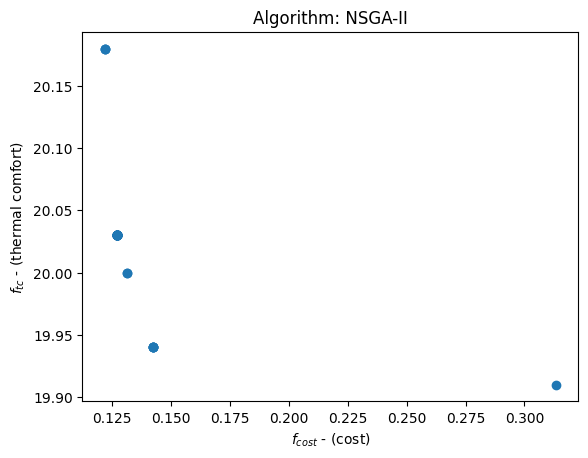

In [ ]:
#Plot the final front
f1 = [i * -1 for i in f_cost]
f2 = [j * -1 for j in f_tc]
print('f1 ',f1)
print('f2 ',f2)
plt.xlabel('$f_{cost}$ - (cost)')
plt.ylabel('$f_{tc}$ - (thermal comfort)')
plt.scatter(f1, f2)
plt.title('Algorithm: NSGA-II')
plt.show()